In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [46]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

In [3]:
# Path to the folder containing images
image_folder = "train/images"
annotations_folder = "train/labelTxt"

In [4]:
# Predefined set of categories
categories = ["Fish", "Crab", "Human", "Trash", "Jelly-fish", "Coral-Reef", "Fish-Group"]

# Create a mapping between categories and numerical labels
label_mapping = {category: label for label, category in enumerate(categories)}

In [5]:
# Reverse the label mapping to create a mapping from numerical labels to categories
reverse_label_mapping = {label: category for category, label in label_mapping.items()}

In [6]:
def decode_label(encodedLabel):
    # Decode the numerical label back to the category
    decoded_label = reverse_label_mapping.get(encodedLabel, "Unknown Category")

    return decoded_label

In [7]:
images = []
annotations = []
labels = []

In [8]:
label_encoder = LabelEncoder()

In [9]:
# List all files in the images folder
for image_name in os.listdir(image_folder):
    if image_name.endswith((".jpg")):
        image_path = os.path.join(image_folder, image_name)
        annotation_path = os.path.join(annotations_folder, image_name.replace(".jpg", ".txt"))  # Assuming annotations are in text files

        # Load the image
        image = cv2.imread(image_path)

        # Read bounding box coordinates from the corresponding annotation file
        bounding_boxes = []
        with open(annotation_path, 'r') as file:
            for line in file:
                values = line.strip().split()  # Assuming format: x_min y_min x_max y_max
                label = values[8]
                # Extract numerical values for bounding box coordinates
                bbox_values = []
                for val in values:
                    try:
                        bbox_values.append(int(val))
                    except ValueError:
                        break  # Skip non-numeric values

                #print("Label: ", label)
                #print("BBox values:", bbox_values)
                
                # Ensure we have a full set of bounding box coordinates
                bounding_boxes = []
                if len(bbox_values) == 8:
                    bounding_box = tuple(bbox_values)
                    bounding_boxes.append(bounding_box)

                #print("Bounding Boxes: ", bounding_boxes)
        
                # Draw bounding boxes on the image
                # X-coordinate of the top-left corner of the bounding box.
                # Y-coordinate of the top-left corner of the bounding box.
                # Width of the bounding box.
                # Height of the bounding box.
                # X-coordinate of the bottom-right corner of the bounding box.
                # Y-coordinate of the bottom-right corner of the bounding box.
                # Depth (a hypothetical value in this context).
                # Confidence score or some other metric related to the annotation.
                for box in bounding_boxes:
                    x_min, y_min, width, height, x_max, y_max, depth, confidence = box
                    
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Draw a green rectangle

                    # Encode the label based on the predefined categories
                    encoded_label = label_mapping.get(label, len(categories)) 
                    #encoded_label = label_encoder.fit_transform([label])[0]
                    
                    images.append(image)
                    annotations.append([x_min, y_min, x_max, y_max])
                    labels.append(encoded_label)

                    #print("File Name: ", image_name)
                    #print("Final Label: ", label, encoded_label)
                    #print("Box: ", x_min, y_min, x_max, y_max)
            
            

        #print(x_min, y_min, x_max, y_max, label)
        #encoded_label = label_encoder.fit_transform([label])[0]
        #annotations.append([x_min, y_min, x_max, y_max])
        #images.append(image)
        #labels.append(encoded_label)

        #labels.append(label)
        #print("Encoded: ", x_min, y_min, x_max, y_max, encoded_label)
        #print("Annotations: ", annotations)
        #print("Labels List:", labels)


        
        # Display the image using matplotlib
        #plt.figure(figsize=(8, 6))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #plt.axis('off')  # Turn off axis numbers
        #plt.title('Annotated Image')
        #plt.show()

# Close all OpenCV windows
cv2.destroyAllWindows()

In [10]:
print(len(annotations))

777


In [11]:
print(len(labels))

777


In [12]:
# Function to preprocess images and annotations
def preprocess_data(images, annotations):
    processed_images = []
    processed_annotations = []
    for image, annotation in zip(images, annotations):

        # Resize image to VGG16 input size (224x224) and normalize pixel values
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize pixel values
        processed_images.append(image)
        
        # Process annotations as needed
        processed_annotations.append(annotation)

        #print(processed_annotations)
    
    return np.array(processed_images), np.array(processed_annotations)

In [13]:
# Preprocess the images and annotations
processed_images, processed_annotations = preprocess_data(images, annotations)

In [14]:
labels = np.array(labels)  

In [15]:
# Create VGG16 model with custom top layers for bounding box prediction and classification
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (2, 2), activation='relu')(x)
x = MaxPooling2D((1, 1))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x_bbox = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions_bbox = Dense(4, activation='linear', name='bounding_box')(x_bbox)  # Output for bounding box coordinates
x_labels = Dense(512, activation='relu')(x)
predictions_labels = Dense(7, activation='softmax', name='classification')(x_labels)  # Output for classification

model = Model(inputs=base_model.input, outputs=[predictions_bbox, predictions_labels])

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Define losses for the two branches
losses = {
    'bounding_box': 'mean_squared_error',
    'classification': 'sparse_categorical_crossentropy'
}

# Define weights for the two losses
loss_weights = {
    'bounding_box': 1.0,
    'classification': 1.0
}



In [16]:
optimizer = tf.keras.optimizers.Adam(0.005)

# Training
model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)

In [17]:
model.fit(processed_images, {'bounding_box': processed_annotations, 'classification': labels}, epochs=1000, batch_size=128)

Epoch 1/1000
7/7 [==============================] - 185s 25s/step - loss: 101224.5469 - bounding_box_loss: 101215.5078 - classification_loss: 7.7933
Epoch 2/1000
7/7 [==============================] - 172s 24s/step - loss: 48727.0781 - bounding_box_loss: 48714.3477 - classification_loss: 11.3244
Epoch 3/1000
7/7 [==============================] - 161s 22s/step - loss: 39188.5820 - bounding_box_loss: 39179.4062 - classification_loss: 7.6527
Epoch 4/1000
7/7 [==============================] - 149s 21s/step - loss: 39220.0078 - bounding_box_loss: 39214.1797 - classification_loss: 4.2762
Epoch 5/1000
7/7 [==============================] - 165s 23s/step - loss: 32916.7930 - bounding_box_loss: 32911.0781 - classification_loss: 4.1108
Epoch 6/1000
7/7 [==============================] - 170s 24s/step - loss: 31268.5996 - bounding_box_loss: 31264.1230 - classification_loss: 2.8680
Epoch 7/1000
7/7 [==============================] - 98s 13s/step - loss: 31090.2676 - bounding_box_loss: 31086.0723

In [19]:
# Evaluation
loss = model.evaluate(processed_images, {'bounding_box': processed_annotations, 'classification': labels})
print(loss)

25/25 [==============================] - 98s 4s/step - loss: 8601.9541 - bounding_box_loss: 8576.2227 - classification_loss: 0.8114
[8601.9541015625, 8576.22265625, 0.8114083409309387]


In [22]:
# Load and preprocess the image
img_path = 'predict_image/d_r_23__jpg.rf.bd64c406b625933319b182360034546c.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values

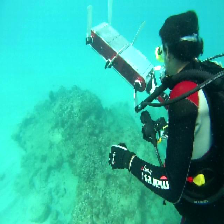

In [23]:
img

In [27]:
# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[1])
decode_predicted_class = decode_label(predicted_class)
#confidence = np.max(predictions)

1/1 [==============================] - 0s 121ms/step


In [30]:
predictions[0]

array([[272.4146  , 118.966354, 476.52972 , 435.9022  ]], dtype=float32)

In [28]:
print(f"Predicted Class: {decode_predicted_class}")

Predicted Class: Human


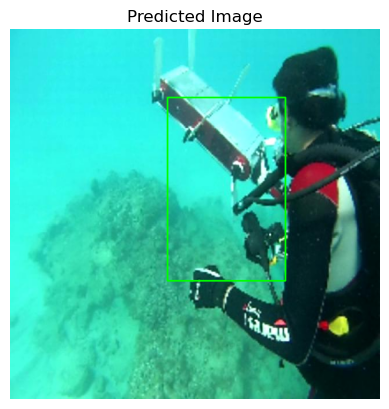

In [42]:
# Convert the Matplotlib plot to a numpy array
img_converted = cv2.imread(img_path)
#img_converted = cv2.resize(img_converted, (224, 224))

for box in predictions[0]:
        x_min, y_min, x_max, y_max = box
        pt1 = (int(x_min), int(y_min))  # Convert to integers
        pt2 = (int(x_max), int(y_max))  # Convert to integers
        cv2.rectangle(img_converted, pt1, pt2, (0, 255, 0), 2)  # Draw a green rectangle

# Display the image using matplotlib
#plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_converted, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis numbers
plt.title('Predicted Image')
plt.show()

In [18]:
# Save the model
model.save('saved_model/comp3704_model.h5')

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('saved_model/comp3704_model.h5')

C:\Users\macyr\AppData\Local\Temp\ipykernel_11972\2079335829.py:22: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "bool"):


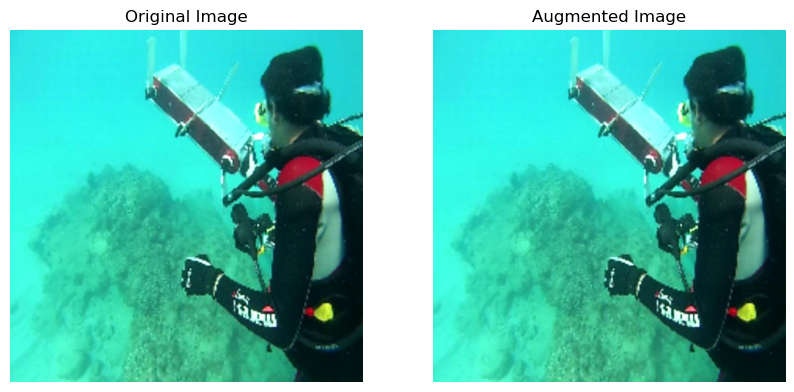

In [53]:
from imgaug import augmenters as iaa

img_path = 'predict_image/d_r_23__jpg.rf.bd64c406b625933319b182360034546c.jpg'

# Load an underwater image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.SomeOf((0, 2), [
        iaa.Multiply((0.5, 1.5)),  # Adjust brightness
        iaa.GaussianBlur(sigma=(0.0, 3.0)),  # Apply Gaussian blur
        iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
        iaa.Affine(rotate=(-45, 45)),  # Random rotation
        iaa.Flipud(0.5),  # Random vertical flip
        iaa.Affine(translate_px={"x": (-50, 50), "y": (-50, 50)})  # Random translation
    ])
], random_order=True)


if not hasattr(np, "bool"):
    np.bool = bool  # Provide the deprecated alias if it's missing

# Augment the image
augmented_image = seq(image=image)

# Display the original and augmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')

plt.show()